<a href="https://colab.research.google.com/github/simulate111/Deep-Learning-in-Human-Language-Technology/blob/main/Exercise%20task%207%20hf_trainer_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* [`evaluate`](https://huggingface.co/docs/evaluate/index) is a library for easily evaluating machine learning models and datasets
* [`accelerate`](https://pypi.org/project/accelerate/) is a wrapper we need to install in order to train torch models using a transformers trainer

Both of these packages are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


* comment: Installing required libraries

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

* comment: use this library to display output in a more beautifull and structured way.

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

* comment: keep log and what is happening during the running to be able to identify any possible problem or what is happen during the running.

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In order to speedup the processing, the unused *unsupervised* partition is deleted and the test section is downsampled.

In [4]:
import datasets


dataset = datasets.load_dataset("imdb")
del dataset["unsupervised"]
dataset=dataset.shuffle()
dataset["test"]=dataset["test"].select(range(400)) # downsample test data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

* comment: imdb database is downloaded and imported from hugging face, then it is shuffled to remove any possible ordering in the dataset.

Let's see what the dataset contains:

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})


and print out an example:

In [6]:
pprint(dataset["train"][0])

{'label': 0,
 'text': "..IT'S THIS ONE! Very cool premise, right off the bat.<br /><br "
         "/>Has an excellent first scene, gotta give credit where credit's "
         'due.<br /><br />Has solid characters and a decent enough script for '
         'a ghost story but here are the things that bothered me: Whenever the '
         'ghosts appeared, which I really liked by the way; how it was done, '
         "how it looked...the only thing was the ghost's relationship. Because "
         "of the way things went down in the first scene you'd think their "
         'dynamic would be different.<br /><br />Things slowed down a little '
         'too much in the middle I felt, and the crab/spider scene was just '
         "not good. BUT then the ending is actually very good! Sure, 'The "
         "Grudge' basically told the same story with a polished lens but no "
         "samurai's and that's what I liked about this movie comparatively.<br "
         '/><br />Please, someone one with a

---

# Tokenize and vectorize data

(This part of the code follows the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in English, and we'll load the tokenizer for the [`bert-base-cased`](https://huggingface.co/bert-base-cased) model.


In [7]:
import transformers

model_name = "bert-base-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


* comment: Here, transformer is used to use pre trained model of bert to initialize weight to achieve higher accuracy and
 less computational proccessing.
 * Autotokenizer select automatically the best tokenizer from the defined model, which is bert-base-cased here.
 * Bert model has been already trained on different resources and it is available to be used through tranformer function to initialize the weight and select the best model for out goal with less effort.

We will define a simple tokenization function and tokenize and vectorize our whole dataset with the tokenizer by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) function.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details). **The maximum sequence length for BERT models is usually 512 due to the trained position embeddings.**

In [8]:
# Define a simple function that applies the tokenizer

# maximum length of BERT models is 512 due to the position embeddings

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

*Comment: bert has the limitation in the number of input token size which is 512. Tokens could be even smaller which may not be good. Other models could enjoy the larger token sizes to see if they could achieve better accuracy or not.

---

# Build model

* Ready-made model implementation from [HF transformers](https://huggingface.co/transformers/)
* BertForSequenceClassification (sequence of tokens in, label out)
  * Pre-trained BERT encoder
  * Pooler output: CLS embedding + linear layer + tanh
  * Classification layer
* [Source code](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/bert/modeling_bert.py#L1501)

In [9]:
import torch
import transformers

model_name = "bert-base-cased"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Comments:

*   bert model is used here through tranformer function from Hugging Face. Automodel will select automativcaly the appropariate model in mentioned model name which is bert-base-cased model for sequence classificaiton.
*   To initialize weights, pre-trained model of bert is used from the already trained model bu others, which is available for transformation training. The model is used here to predict the imdb database whether comment are positive or negative leading to two label classes or output.
* Forsequenceclassification explicitly mention that the model will be use for classification of a sequence of iput to select the related model for our case.



---

# Configure and train model

The following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `per_device_eval_batch_size`: number of examples per evaluate batch (larger number makes evaluation faster, but requires more memory)
* `max_steps`: the maximum number of steps to train for

In [10]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=500,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


* comment: the model is configured here. Some features are manadatory while others may be optional to be defined or will be defined by default. We will save log and evaluate the model at each 100 steps of calculation.
*per device bathc size is use for faster computation if there is such availability in our computation resources.
*learning rate is one of the hyperparameter which is the rate of updating weight and usually should be explored to identify the best one.

We'll then define the standard accuracy metric (ratio of correct out of all predictions), create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.


In [11]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

* Comment: here, the way of evaluating the model and how calculating accuracy is set. Predicted labels are compared with real labels to calculate the model accuracy.
* Collator is used in natural language processign to prepare our data for training such as ensuraing the input sequence sizes are the same by like padding method with zeros. Or, if the imput is long, it cut the length to have the same size.

Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [12]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [13]:
print(dataset["test"]["label"][:50]) # print a sample of test labels to see that they are not ordered

trainer = None
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Accuracy
100,0.651100,0.561125,0.775000
200,0.427500,0.317101,0.872500
300,0.299400,0.283745,0.890000
400,0.318900,0.253722,0.902500
500,0.279500,0.257191,0.905000


TrainOutput(global_step=500, training_loss=0.3952727088928223, metrics={'train_runtime': 414.6465, 'train_samples_per_second': 9.647, 'train_steps_per_second': 1.206, 'total_flos': 988919346011520.0, 'train_loss': 0.3952727088928223, 'epoch': 0.16})

---

# Results

* comment: the model is trained here based on the training data set. The model also evaluated based on the defined evaluation model and available test dataset. Logging, tokenizing, and collator are applied in the model to achieve output.

Evaluate and print out results:

In [14]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 0.16,
 'eval_accuracy': 0.905,
 'eval_loss': 0.25719061493873596,
 'eval_runtime': 11.5957,
 'eval_samples_per_second': 34.496,
 'eval_steps_per_second': 1.121}
Accuracy: 0.905


Comments:


*   Comparing the accuracy values here with the previous week excercise on RNN, the accuracy is much higher here which was aorunf 0.6.
*   Using pre trained model and tranfomer functionality, makes us capable to use already trained or defined weight with the similar problem to enhance the accuracy with less effort. However, the previous excercise requires much higher effort to optimize hyperparameter to be able to precisely discuss how better or worse are models compared to each other. THis is while, bert takes advantage of being already trained and required less effort to be tunned and optimized.
* Bert seems to be better at understanding language and general text which generally lead to higher accuracy rather than CNN and RNN.
* Bert also could be imagined to work better on a database like imdb as it was already trained on the available data which may include imdb too.
* Taking advantage of attention, bert again could works better and adjust weight separately and better.



Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

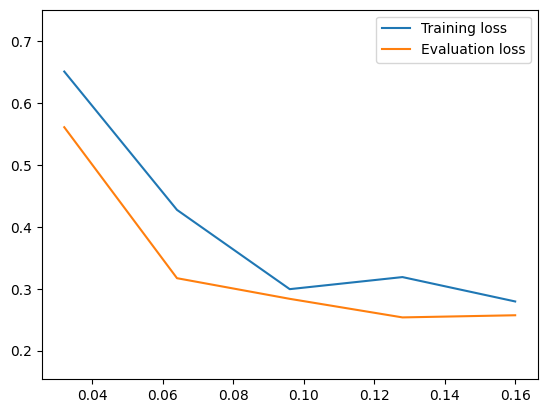

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

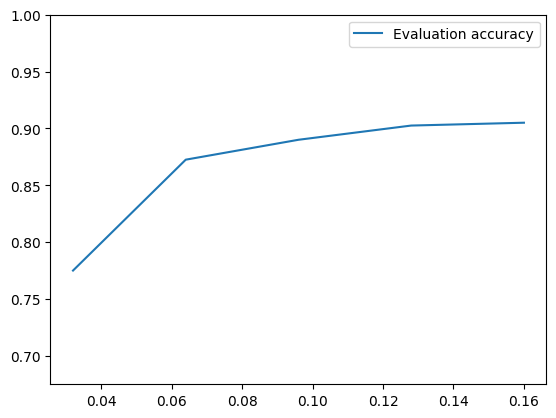

In [16]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])